In [1]:
pip install mysql-connector-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 31.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 24.0 MB/s eta 0:00:0000:01:02

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [54]:
pip install streamlit matplotlib



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install python-dotenv


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install SQLAlchemy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 14.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 30.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [65]:
pip install dash jupyter-dash plotly


Note: you may need to restart the kernel to use updated packages.


**1. Extract Data from MySQL:**

We will first extract the data from TransformedProductData for the demand forecasting task.


In [10]:
import pandas as pd
import mysql.connector
import os
from sqlalchemy import create_engine
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Function to create the SQLAlchemy engine for MySQL connection
def create_db_connection():
    try:
        # Retrieve database credentials from environment variables
        db_user = os.getenv("DB_USER")
        db_password = os.getenv("DB_PASSWORD")
        db_host = os.getenv("DB_HOST")
        db_port = os.getenv("DB_PORT")
        db_name = os.getenv("DB_NAME")
        ssl_ca_path = os.getenv("SSL_CA_PATH")
        
        # Create a SQLAlchemy engine for MySQL
        engine = create_engine(
            f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}",
            connect_args={'ssl_ca': ssl_ca_path}
        )
        return engine
    except Exception as err:
        print(f"Error connecting to database: {err}")
        return None

# Function to extract the data from TransformedProductData
def extract_demand_data(engine):
    try:
        query = """
        SELECT 
            product_id ,
            product_name ,
            inventory_date ,
            inventory_qty ,
            original_price_per_unit ,
            inventory_value ,
            sale_price_per_unit ,
            total_items_sold ,
            total_sales_value,
            total_profit ,
            avg_items_sold_per_month ,
            avg_sales_revenue_per_month ,
            avg_profit_per_month ,
            warehouse_location ,
            lead_time_days ,
            season
        FROM TransformedProductData;
        """

        # Read the query result into a DataFrame using the SQLAlchemy engine
        df = pd.read_sql(query, engine)

        # Show the first few rows of the DataFrame
        print(df.head())  # Display the first 5 rows of the extracted data
        return df
    except Exception as err:
        print(f"Error extracting data: {err}")
        return None

# Example usage
if __name__ == "__main__":
    engine = create_db_connection()
    if engine:
        df = extract_demand_data(engine)
        if df is not None:
            print("Data extraction successful!")
        else:
            print("Data extraction failed.")
    else:
        print("Database connection failed.")


   product_id     product_name inventory_date  inventory_qty  \
0        1001   Wireless Mouse     2024-01-01            100   
1        1002       HDMI Cable     2024-10-01            200   
2        1005       Smartwatch     2024-01-02            120   
3        1006   Gaming Headset     2024-05-02            200   
4        1007  Fitness Tracker     2024-10-02            300   

   original_price_per_unit  inventory_value  sale_price_per_unit  \
0                     15.0           1500.0                 25.0   
1                      8.0           1600.0                 12.0   
2                     50.0           6000.0                 80.0   
3                     30.0           6000.0                 45.0   
4                     55.0          16500.0                 85.0   

   total_items_sold  total_sales_value  total_profit  \
0                60             1500.0           0.0   
1               120             1440.0        -160.0   
2               100             8000.0

**2. Preprocess the Data:**

For forecasting, we need to preprocess the data by handling missing values, aggregating sales by time period (e.g., monthly), and ensuring the data is in a format suitable for time-series forecasting.

**1 Changing the Appropriate Data Type**

In [11]:
df['inventory_date'] = pd.to_datetime(df['inventory_date'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   product_id                   29 non-null     int64         
 1   product_name                 29 non-null     object        
 2   inventory_date               29 non-null     datetime64[ns]
 3   inventory_qty                29 non-null     int64         
 4   original_price_per_unit      29 non-null     float64       
 5   inventory_value              29 non-null     float64       
 6   sale_price_per_unit          29 non-null     float64       
 7   total_items_sold             29 non-null     int64         
 8   total_sales_value            29 non-null     float64       
 9   total_profit                 29 non-null     float64       
 10  avg_items_sold_per_month     29 non-null     float64       
 11  avg_sales_revenue_per_month  29 non-null     fl

**2 Handling Duplicated Data**

In [12]:
# Check for duplicate data
df.duplicated().sum()

np.int64(0)

**3 Handling Missing Value**

In [13]:
# Check for missing values
def check_null(df) :
    col_na = df.isnull().sum().sort_values(ascending=False)
    percent = round((col_na/len(df))*100,3)
    missing_data = pd.concat([col_na, percent],axis=1, keys=['Total Missing Values','Percentage(%)'])
    print(missing_data[missing_data['Total Missing Values'] > 0])
    
check_null(df) 

Empty DataFrame
Columns: [Total Missing Values, Percentage(%)]
Index: []


**Data For Machine Learning Modeling**

1 Inventory Data

In [14]:
df_inventory = df[['inventory_date','inventory_qty']]
df_inventory = df_inventory.groupby('inventory_date')['inventory_qty'].sum().reset_index()
df_inventory = df_inventory.sort_values(by='inventory_date')
df_inventory.head()

inventory_date  inventory_qty
0     2024-01-01            200
1     2024-01-02            240
2     2024-01-03            500
3     2024-01-04            150
4     2024-01-05            200

In [15]:
df_inventory.tail()

inventory_date  inventory_qty
10     2024-10-02            600
11     2024-10-03            160
12     2024-10-04            400
13     2024-10-05            180
14     2024-11-01            500

In [16]:
# Assuming 'df' contains product-related data and transaction information

df_inventory = df.groupby('product_id').agg(
    
    # Aggregating product-related columns
    Total_Items_Sold=pd.NamedAgg(column='total_items_sold', aggfunc='sum'),
    Total_Sales_Value=pd.NamedAgg(column='total_sales_value', aggfunc='sum'),
    Total_Profit=pd.NamedAgg(column='total_profit', aggfunc='sum'),
    Avg_Items_Sold_Per_Month=pd.NamedAgg(column='avg_items_sold_per_month', aggfunc='mean'),
    Avg_Sales_Revenue_Per_Month=pd.NamedAgg(column='avg_sales_revenue_per_month', aggfunc='mean'),
    Avg_Profit_Per_Month=pd.NamedAgg(column='avg_profit_per_month', aggfunc='mean'),
    Lead_Time_Days=pd.NamedAgg(column='lead_time_days', aggfunc='mean'),
    Season=pd.NamedAgg(column='season', aggfunc=lambda x: x.mode()[0])  # Get the most frequent season
).reset_index()

# Optionally, sort by 'product_id' (or any other column you wish to)
df_inventory = df_inventory.sort_values(by='product_id', ascending=True)

# Display the top rows of the new dataframe
df_inventory.head()


product_id  Total_Items_Sold  Total_Sales_Value  Total_Profit  \
0        1001                60             1500.0           0.0   
1        1002               120             1440.0        -160.0   
2        1005               100             8000.0        2000.0   
3        1006               150             6750.0         750.0   
4        1007               200            17000.0         500.0   

   Avg_Items_Sold_Per_Month  Avg_Sales_Revenue_Per_Month  \
0                      5.00                       125.00   
1                     10.00                       120.00   
2                      8.33                       666.67   
3                     12.50                       562.50   
4                     16.67                      1416.67   

   Avg_Profit_Per_Month  Lead_Time_Days   Season  
0                  0.00            30.0  Unknown  
1                -13.33            25.0  Unknown  
2                166.67            40.0  Unknown  
3                 62.50            30.0  Unknown  
4                 41.67            35.0  Unknown

**4. Exploratory Data Analysis (EDA)**

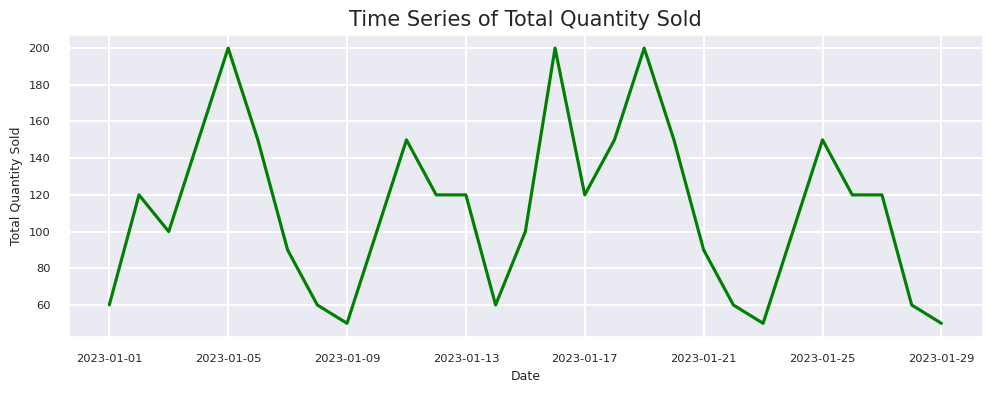

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Simulating a Date column assuming monthly data starting from January 2023
df_inventory['Date'] = pd.date_range(start='2023-01-01', periods=len(df_inventory), freq='D')

# Now plotting the Total Quantity (for example, Total_Quantity sold by product over time)
sns.set_context("talk", font_scale=0.5)
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.lineplot(x='Date', y='Total_Items_Sold', data=df_inventory, color='green')
    plt.title('Time Series of Total Quantity Sold', fontsize=15)
    plt.xlabel('Date')
    plt.ylabel('Total Quantity Sold')
    
plt.tight_layout()
plt.show()


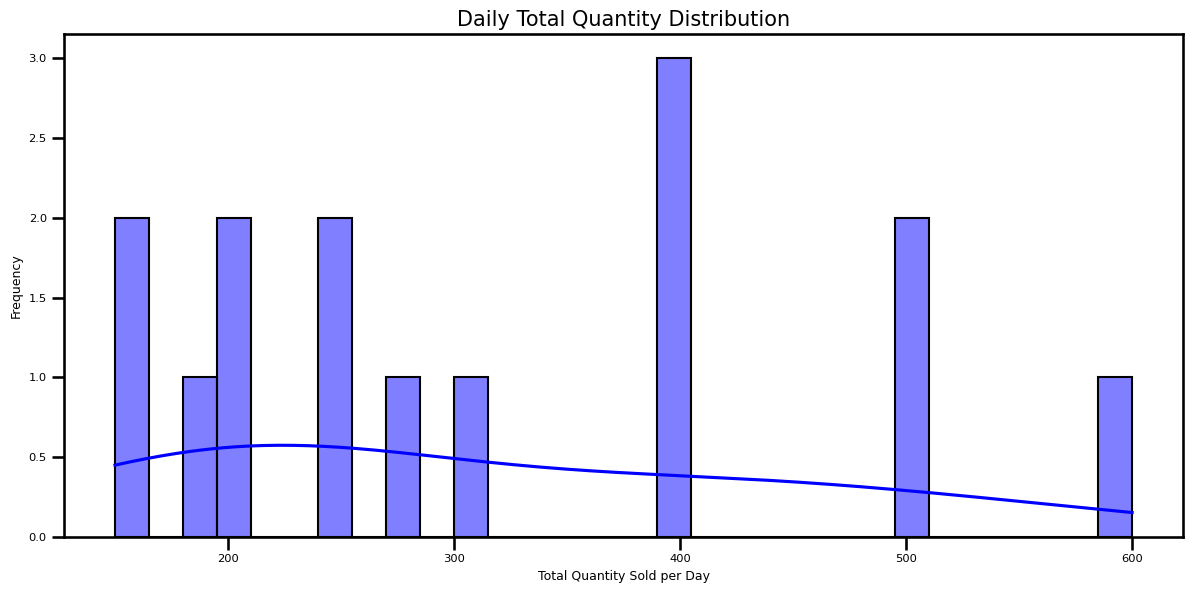

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df contains your inventory data
# Convert to DataFrame if it's not already
df_inventory = pd.DataFrame(df)

# Ensure 'inventory_date' is in datetime format
df_inventory['inventory_date'] = pd.to_datetime(df_inventory['inventory_date'])

# Group by 'inventory_date' and sum the 'inventory_qty' for each day
df_daily_qty = df_inventory.groupby('inventory_date')['inventory_qty'].sum().reset_index()

# Set up the plot size and style
sns.set_context("talk", font_scale=0.5)
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust size for readability

# Create a distribution plot (histogram) for daily total quantity
sns.histplot(df_daily_qty['inventory_qty'], kde=True, color='blue', ax=ax, bins=30)

# Add Title and Labels
ax.set_title('Daily Total Quantity Distribution', fontsize=15)
ax.set_xlabel('Total Quantity Sold per Day')
ax.set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


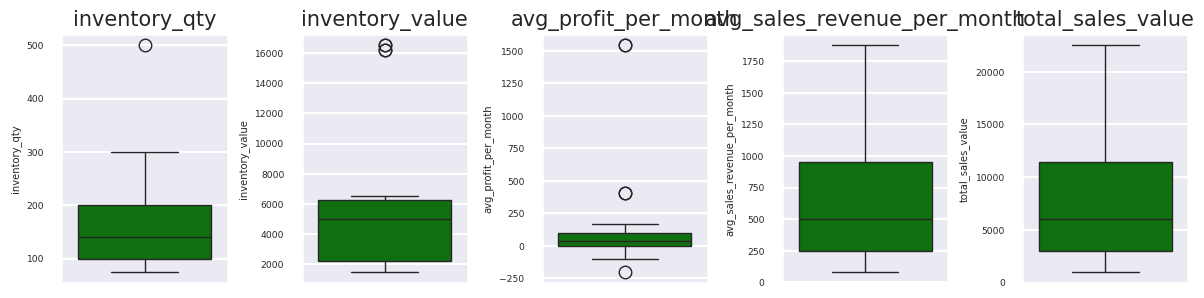

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_marketing contains your relevant data
cols = ['inventory_qty', 'inventory_value', 'avg_profit_per_month', 'avg_sales_revenue_per_month', 'total_sales_value']

# Set the plot size and context
plt.figure(figsize=(12, 3))
sns.set_context("talk", font_scale=0.4)

# Use 'axes_style' for aesthetic customization
with sns.axes_style("darkgrid"):
    # Loop through each column in 'cols' and create a boxplot for each
    for i, col in enumerate(cols, 1):
        plt.subplot(1, len(cols), i)  # Adjust the number of subplots dynamically based on the length of 'cols'
        sns.boxplot(data=df_inventory, y=col, color='green', orient='v')  # Create boxplot for each column
        plt.title(f'{col}', fontsize=15)  # Title for each subplot

# Adjust the layout for better spacing
plt.tight_layout()
plt.show()


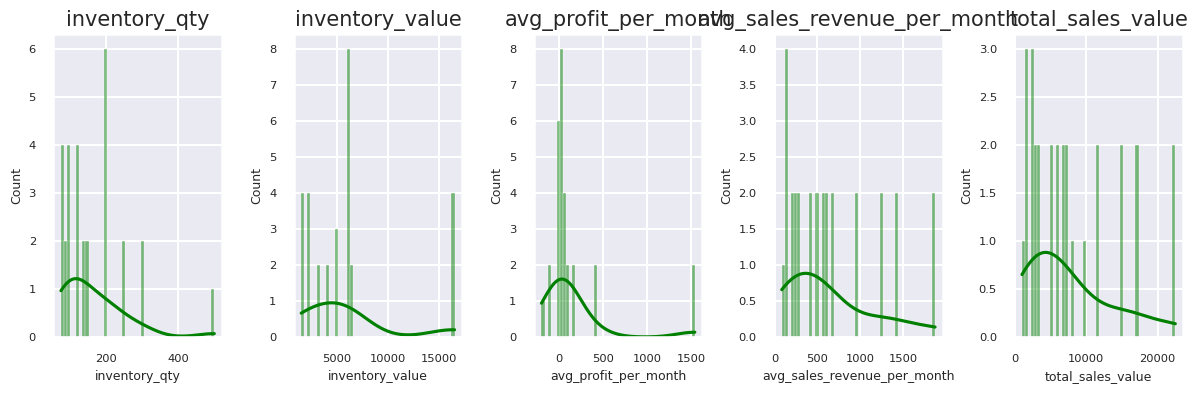

In [20]:


# Assuming df_marketing contains your relevant data
cols = ['inventory_qty', 'inventory_value', 'avg_profit_per_month', 'avg_sales_revenue_per_month', 'total_sales_value']

# Set the plot size and context
plt.figure(figsize=(12, 4))
sns.set_context("talk", font_scale=0.5)

# Use 'axes_style' for aesthetic customization
with sns.axes_style("darkgrid"):
    # Loop through each column in 'cols' and create a distribution plot for each
    for i, col in enumerate(cols, 1):
        plt.subplot(1, len(cols), i)  # Adjust the number of subplots dynamically based on the length of 'cols'
        sns.histplot(df_inventory[col], color='green', bins=50, kde=True)  # Create histogram with KDE (Kernel Density Estimation)
        plt.title(f'{col}', fontsize=15)  # Title for each subplot

# Adjust the layout for better spacing
plt.tight_layout()
plt.show()


In [21]:
# Strip leading/trailing spaces from column names
df_inventory.columns = df_inventory.columns.str.strip()


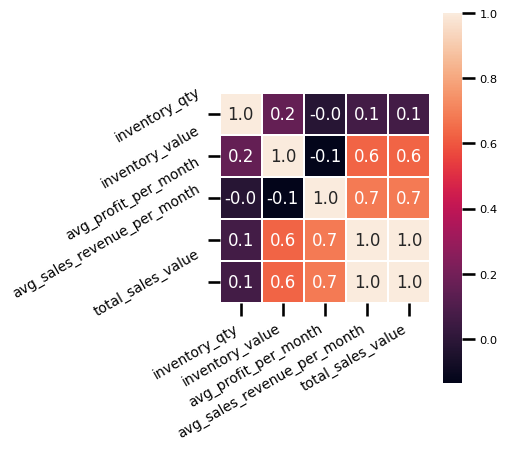

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_inventory contains the necessary data
# Define the columns you want to analyze for correlation
cols = ['inventory_qty', 'inventory_value', 'avg_profit_per_month', 
        'avg_sales_revenue_per_month', 'total_sales_value']

# Calculate the correlation matrix for the selected columns
plt.figure(figsize=(5, 5))

# Generate the correlation matrix
corrmat = df_inventory[cols].corr()

# Create the heatmap
sns.heatmap(corrmat, annot=True, fmt='.1f', vmin=corrmat.values.min(), vmax=1, square=True,
            linewidths=0.1, annot_kws={"fontsize": 12})

# Adjust x and y tick labels for better readability
plt.xticks(rotation=30, horizontalalignment='right', fontsize=10)
plt.yticks(rotation=30, fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


**Machine Learning Modeling**
ARIMA Modeling

In [23]:
train_size = int(len(df_inventory) * 0.9)
train = df_inventory[:train_size]
test = df_inventory[train_size:]

In [24]:
train.shape


(26, 16)

In [25]:
test.shape


(3, 16)

In [29]:
# 2 Augmented Dickey Fuller (ADF) Test
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Assuming df_inventory contains the relevant columns
# Function to perform Augmented Dickey-Fuller Test
def adf_test(data):
    # Apply the Augmented Dickey-Fuller test
    result = adfuller(data)
    
    # Print the ADF Statistic, p-value, and critical values
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    # Conclusion based on p-value
    if result[1] > 0.05:
        print('Conclusion: Non-stationary Data')
    else:
        print('Conclusion: Stationary Data')

# Example usage with columns from df_inventory
# Select a column for testing (e.g., 'inventory_qty')
print('ADF test on Inventory Quantity:')
adf_test(df_inventory['inventory_qty'])

# You can also test other numerical columns similarly:
print('\nADF test on Inventory Value:')
adf_test(df_inventory['inventory_value'])

print('\nADF test on Total Sales Value:')
adf_test(df_inventory['total_sales_value'])

# Additional columns can be tested by simply calling the function with the column name as input.



ADF test on Inventory Quantity:
ADF Statistic: -3.110848
p-value: 0.025761
Critical Values:
	1%: -3.689
	5%: -2.972
	10%: -2.625
Conclusion: Stationary Data

ADF test on Inventory Value:
ADF Statistic: -1.622586
p-value: 0.471374
Critical Values:
	1%: -3.833
	5%: -3.031
	10%: -2.656
Conclusion: Non-stationary Data

ADF test on Total Sales Value:
ADF Statistic: -2.493456
p-value: 0.117075
Critical Values:
	1%: -3.833
	5%: -3.031
	10%: -2.656
Conclusion: Non-stationary Data


Index(['product_id', 'product_name', 'inventory_date', 'inventory_qty',
       'original_price_per_unit', 'inventory_value', 'sale_price_per_unit',
       'total_items_sold', 'total_sales_value', 'total_profit',
       'avg_items_sold_per_month', 'avg_sales_revenue_per_month',
       'avg_profit_per_month', 'warehouse_location', 'lead_time_days',
       'season'],
      dtype='object')


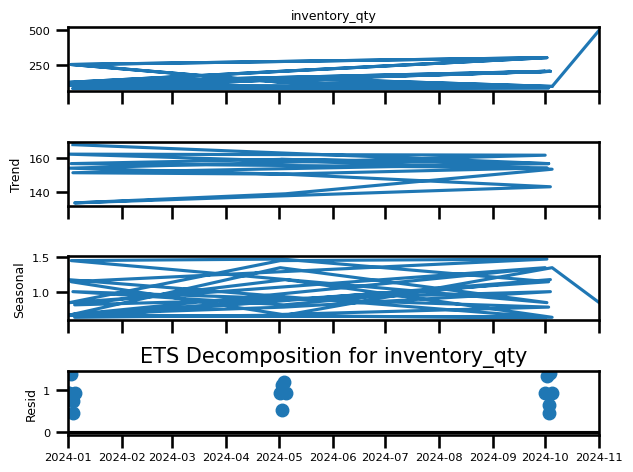

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Check the column names to confirm the 'inventory_date' column exists
print(df_inventory.columns)

# If the 'inventory_date' column exists but is the index, reset it
df_inventory.reset_index(inplace=True)  # If 'inventory_date' is the index

# Ensure 'inventory_date' is in datetime format and set as index
df_inventory['inventory_date'] = pd.to_datetime(df_inventory['inventory_date'])
df_inventory.set_index('inventory_date', inplace=True)

# For example, we will perform ETS decomposition on 'inventory_qty'
column_to_decompose = 'inventory_qty'

# Ensure that the column to decompose is numerical and set appropriate period
n_obs = df_inventory[column_to_decompose].shape[0]
period = 12  # Assuming monthly data (12 months for yearly seasonality)

# Perform ETS decomposition using the additive or multiplicative model based on the nature of the data
try:
    result = seasonal_decompose(df_inventory[column_to_decompose], model='multiplicative', period=period)

    # Plot the decomposition results
    result.plot()
    plt.title(f'ETS Decomposition for {column_to_decompose}', fontsize=15)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error during decomposition: {e}")


In [31]:
import statsmodels.api as sm

# Assuming 'inventory_qty' is the numeric time series column you want to forecast
model5 = sm.tsa.ARIMA(train['inventory_qty'], order=(3, 0, 3))  # p=3, d=0, q=3
results5 = model5.fit()
print(results5.summary())


                               SARIMAX Results                                
Dep. Variable:          inventory_qty   No. Observations:                   26
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -137.329
Date:                Tue, 12 Nov 2024   AIC                            290.658
Time:                        15:45:52   BIC                            300.723
Sample:                             0   HQIC                           293.557
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.0787      2.051     74.165      0.000     148.060     156.098
ar.L1          1.1801      0.626      1.885      0.059      -0.047       2.407
ar.L2         -0.2171      0.543     -0.400      0.6

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


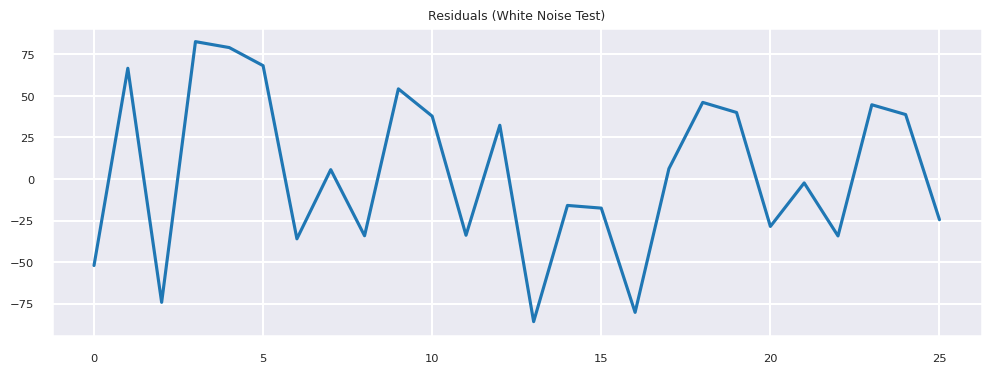

In [32]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already set the index to the 'inventory_date' or 'total_sales_value'
# Fit the ARIMA model with p=3, d=0, q=3 (adjust according to your case)
model3 = sm.tsa.ARIMA(train['inventory_qty'], order=(3, 0, 3))  # Example: inventory_qty as the time series
results3 = model3.fit()

# Extract residuals
residuals = results3.resid

# Plot residuals
sns.set_context("talk", font_scale=0.5)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12, 4))
    plt.plot(residuals)
    plt.title('Residuals (White Noise Test)')
    plt.show()


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


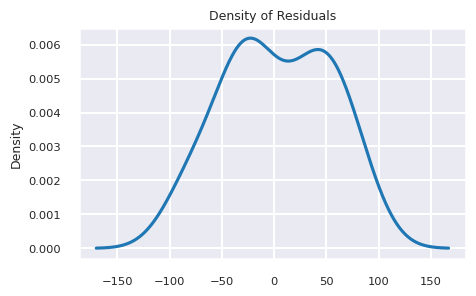

Shapiro-Wilk Test Stat: 0.949409721370511, p-value: 0.2246254566753353


In [33]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Fit the ARIMA model (adjust according to your dataset)
model = sm.tsa.ARIMA(train['inventory_qty'], order=(3, 0, 3))  # Example: inventory_qty as the time series
results = model.fit()

# Extract residuals
residuals = results.resid

# Plot KDE of residuals (Density plot for normality)
sns.set_context("talk", font_scale=0.5)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(5, 3))
    residuals.plot(kind='kde', title='Density of Residuals')
    plt.show()

# Normality Test (Shapiro-Wilk Test as an example)
stat, p_value = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test Stat: {stat}, p-value: {p_value}")

# If the p-value is above 0.05, we fail to reject the null hypothesis (residuals are normally distributed).


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_6558/2781646935.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['forecast'] = forecast


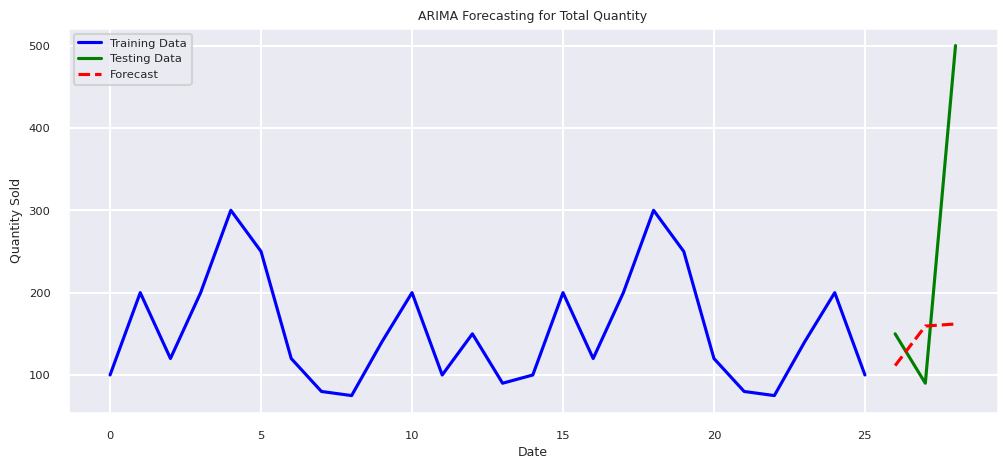

In [35]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Example of ARIMA model for forecasting
# Fit the ARIMA model to the training data (inventory_qty)
model = sm.tsa.ARIMA(train['inventory_qty'], order=(3, 0, 3))  # Adjust order as needed
results = model.fit()

# Forecast the future quantity (steps = len of test data)
forecast = results.forecast(steps=len(test))

# Store forecast in the test dataframe
test['forecast'] = forecast

# Visualize the training data, testing data, and forecasted values
sns.set_context("talk", font_scale=0.5)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12, 5))
    plt.plot(train['inventory_qty'], label='Training Data', color='blue')
    plt.plot(test['inventory_qty'], label='Testing Data', color='green')
    plt.plot(test['forecast'], label='Forecast', linestyle='--', color='red')
    plt.legend()
    plt.title('ARIMA Forecasting for Total Quantity')
    plt.xlabel('Date')
    plt.ylabel('Quantity Sold')
    plt.show()



MAE  : 151.33560791278657
MAPE : 0.5659050659734325
RMSE : 205.8565381674172


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


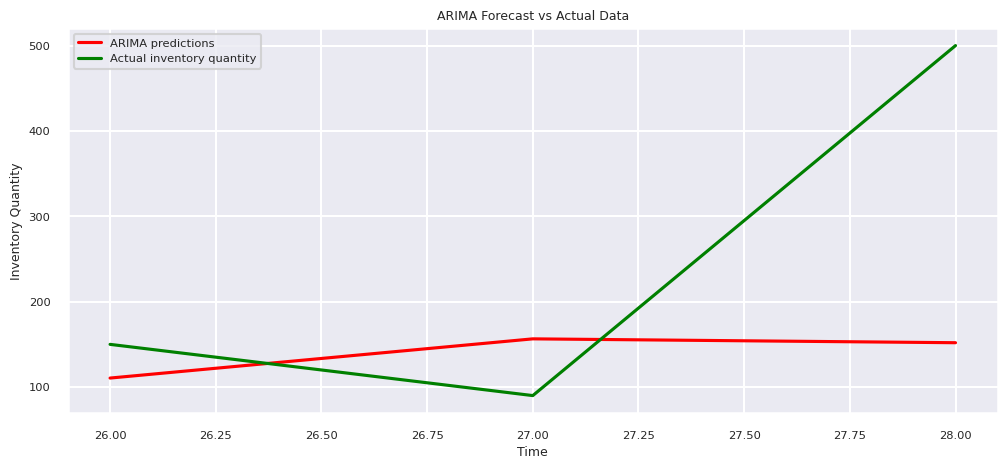

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm

# Assuming 'train' contains your historical product data with 'inventory_qty' to forecast

# Define and train the ARIMA model
# Example: ARIMA(p, d, q) where p, d, q are the model parameters
p, d, q = 3, 1, 2  # Example values, you may want to adjust based on your data
model = sm.tsa.ARIMA(train['inventory_qty'], order=(p, d, q))
results6 = model.fit()

# Forecasting with ARIMA model
forecast = results6.forecast(steps=len(test))  # Forecast for the length of the test set

# Calculate evaluation metrics
mae = mean_absolute_error(test['inventory_qty'], forecast)
mape = mean_absolute_percentage_error(test['inventory_qty'], forecast)
rmse = np.sqrt(mean_squared_error(test['inventory_qty'], forecast))

# Print evaluation metrics
print(f'MAE  : {mae}')
print(f'MAPE : {mape}')
print(f'RMSE : {rmse}')

# Visualizing the ARIMA forecast vs actual data
sns.set_context("talk", font_scale=0.5)

with sns.axes_style("darkgrid"):
    # Set the start and end points for the forecasted data
    start = len(train)  # Assuming 'train' is your training data containing historical data
    end = len(train) + len(test) - 1  # End index for test data length

    # Generate forecast values from the ARIMA model (use 'levels' for forecast in terms of actual values)
    pred = results6.predict(start=start, end=end, typ='levels').rename('ARIMA predictions')

    # Plotting the forecasted values and actual values (inventory_qty)
    plt.figure(figsize=(12, 5))
    pred.plot(legend=True, label='ARIMA predictions', color='red')
    test['inventory_qty'].plot(legend=True, label='Actual inventory quantity', color='green')
    plt.title('ARIMA Forecast vs Actual Data')
    plt.xlabel('Time')
    plt.ylabel('Inventory Quantity')
    plt.legend()
    plt.show()


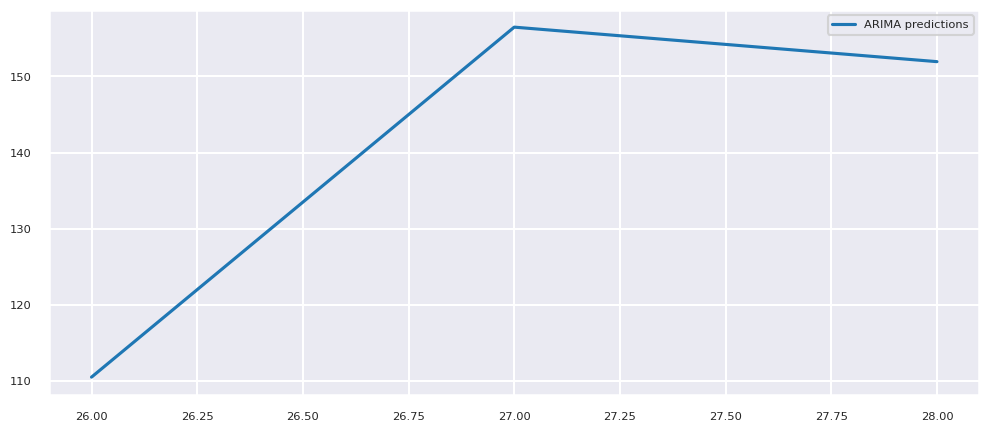

In [37]:
sns.set_context("talk", font_scale=0.5)
with sns.axes_style("darkgrid"):
    pred.plot(figsize=(12,5),legend=True)

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dat

MAE: 1.7429686846498813
MAPE: 0.2460080628252019
RMSE: 2.2073939854049285


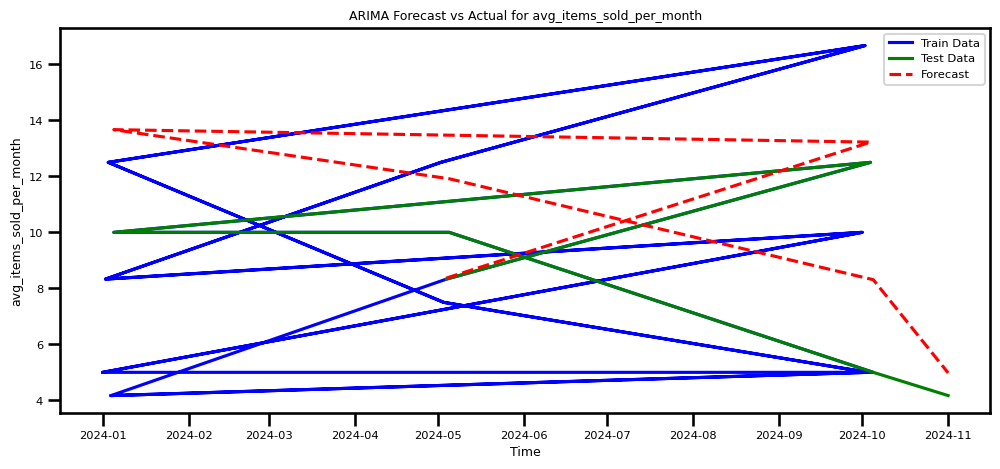

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Assuming you have a dataset 'df' containing 'inventory_date', 'inventory_qty', 'avg_items_sold_per_month', etc.

# Step 1: Prepare the data
# Set 'inventory_date' as the index and ensure it's in datetime format
df['inventory_date'] = pd.to_datetime(df['inventory_date'])
df.set_index('inventory_date', inplace=True)

# Step 2: Train-Test Split (80% train, 20% test)
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

# Step 3: Choose a target variable (e.g., avg_items_sold_per_month for demand forecasting)
target = 'avg_items_sold_per_month'  # This could be 'inventory_qty' or any other column you're forecasting

# Step 4: Fit the ARIMA model on the training data
# Here we use ARIMA(p, d, q), you can fine-tune these parameters (p, d, q)
model = ARIMA(train[target], order=(5, 1, 0))  # Example: ARIMA(5,1,0), this can be tuned further
results = model.fit()

# Step 5: Forecast using the trained model
forecast_steps = len(test)
forecast = results.forecast(steps=forecast_steps)

# Step 6: Evaluate the model using performance metrics
mae = mean_absolute_error(test[target], forecast)
mape = mean_absolute_percentage_error(test[target], forecast)
rmse = np.sqrt(mean_squared_error(test[target], forecast))

# Print evaluation metrics
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'RMSE: {rmse}')

# Step 7: Visualizing the forecasted and actual values
sns.set_context("talk", font_scale=0.5)

plt.figure(figsize=(12, 5))
plt.plot(train.index, train[target], label='Train Data', color='blue')
plt.plot(test.index, test[target], label='Test Data', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--')
plt.title(f'ARIMA Forecast vs Actual for {target}')
plt.xlabel('Time')
plt.ylabel(target)
plt.legend()
plt.show()


In [82]:
# Import required libraries
import dash
import dash_core_components as dcc
import dash_html_components as html
from jupyter_dash import JupyterDash
import plotly.express as px
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Function to calculate Safety Stock
def calculate_safety_stock(demand_variance, lead_time, z_score=1.96):
    return z_score * np.sqrt(lead_time * demand_variance)

# Function to calculate Economic Order Quantity (EOQ)
def calculate_eoq(demand, ordering_cost, holding_cost):
    return np.sqrt((2 * demand * ordering_cost) / holding_cost)

# Function to calculate Reorder Point (ROP)
def calculate_reorder_point(daily_demand, lead_time, safety_stock):
    return (daily_demand * lead_time) + safety_stock

# Function for Total Cost optimization
def total_inventory_cost(order_qty, demand, holding_cost, ordering_cost, stockout_cost, lead_time, safety_stock):
    avg_inventory = order_qty / 2 + safety_stock
    holding_cost_total = avg_inventory * holding_cost
    ordering_cost_total = demand / order_qty * ordering_cost
    stockout_occurrences = max(0, demand - order_qty)
    stockout_cost_total = stockout_occurrences * stockout_cost
    return holding_cost_total + ordering_cost_total + stockout_cost_total

# Optimization for EOQ
def optimize_inventory(demand, holding_cost, ordering_cost, stockout_cost, lead_time, safety_stock):
    result = minimize(total_inventory_cost, 
                      x0=100,
                      args=(demand, holding_cost, ordering_cost, stockout_cost, lead_time, safety_stock),
                      bounds=((1, None),))
    return result.x[0]

# Calculate sales efficiency for all products
df_inventory['sales_efficiency'] = df_inventory['avg_items_sold_per_month'] / df_inventory['inventory_qty']
average_efficiency = df_inventory['sales_efficiency'].mean()

# Define a threshold for overstock detection (adjustable based on your data)
efficiency_threshold = average_efficiency * 0.5

# List to store recommendations
recommendations = []

# Process each product in df_inventory
for index, row in df_inventory.iterrows():
    demand_per_year = row['total_items_sold'] * 12
    daily_demand = demand_per_year / 365
    lead_time_days = row['lead_time_days']
    holding_cost_per_unit = row['original_price_per_unit'] * 0.05
    ordering_cost_per_order = 50
    stockout_cost_per_unit = 10
    current_inventory = row['inventory_qty']
    demand_variance = row['avg_items_sold_per_month'] * 0.5

    # Calculate Safety Stock
    safety_stock = calculate_safety_stock(demand_variance, lead_time_days)
    
    # Calculate EOQ
    eoq = calculate_eoq(demand_per_year, ordering_cost_per_order, holding_cost_per_unit)
    
    # Calculate Reorder Point
    reorder_point = calculate_reorder_point(daily_demand, lead_time_days, safety_stock)
    
    # Optimize Inventory using cost minimization
    optimal_order_qty = optimize_inventory(demand_per_year, holding_cost_per_unit, ordering_cost_per_order,
                                           stockout_cost_per_unit, lead_time_days, safety_stock)
    
    # Calculate product's sales efficiency
    sales_efficiency = row['avg_items_sold_per_month'] / current_inventory
    
    # Determine inventory status
    if current_inventory > eoq:
        if sales_efficiency < efficiency_threshold:
            inventory_status = 'Overstock'
            recommendations.append(f"Consider discounting {row['product_name']} to reduce excess stock.")
        else:
            inventory_status = 'Excess Stock (but selling well)'
            recommendations.append(f"Keep {row['product_name']} in stock due to high demand.")
    elif current_inventory < reorder_point:
        inventory_status = 'Understock'
        recommendations.append(f"Reorder {row['product_name']} to avoid stockouts.")
    else:
        inventory_status = 'Optimal'
        recommendations.append(f"{row['product_name']} is optimally stocked.")
    
    # Update DataFrame with recommendations
    df_inventory.at[index, 'inventory_status'] = inventory_status

# Create a bar chart for inventory status distribution
status_counts = df_inventory['inventory_status'].value_counts()
status_fig = px.bar(status_counts, x=status_counts.index, y=status_counts.values, 
                    labels={'x': 'Inventory Status', 'y': 'Number of Products'},
                    title='Inventory Status Distribution')

# Create the Dash app using JupyterDash
app = JupyterDash(__name__)

# Dashboard Layout
app.layout = html.Div([
    html.H1("Inventory Dashboard"),
    
    # Display the DataFrame
    html.Div([
        html.H3("Product Inventory Data"),
        html.Div([
            html.Div([html.P(f"Recommendations for each product:")], style={"font-weight": "bold"}),
            html.Div([html.P(f"{rec}") for rec in recommendations], style={"margin": "10px"})
        ]),
        dcc.Graph(figure=status_fig),
        
        html.Div([
            html.H3("Product Inventory Overview"),
            html.Table([
                html.Tr([html.Th(col) for col in df_inventory.columns]),
                *[html.Tr([html.Td(df_inventory[col].iloc[i]) for col in df_inventory.columns]) for i in range(len(df_inventory))]
            ])
        ])
    ])
])

# Run the app inline within the notebook
app.run_server(debug=True, use_reloader=False)


/usr/local/python/3.12.1/lib/python3.12/site-packages/dash/dash.py:579: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



TypeError: 'NoneType' object cannot be interpreted as an integer